In [2]:

from taco_dataset import CoCoDatasetForYOLO
import albumentations as A
import cv2
import torch

import torchvision.transforms as transforms

from albumentations.pytorch import ToTensorV2
from utils import (
    cellboxes_to_boxes,
    non_max_suppression,
    plot_image
)

IMAGE_SIZE = 448
scale = 1.12

train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.Affine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [3]:
dataset_path = '../downloads/TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [4]:
dataset = CoCoDatasetForYOLO(
    root=dataset_path, 
    annFile=anns_file_path,
    C=1
)

dataset.transform = train_transforms

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


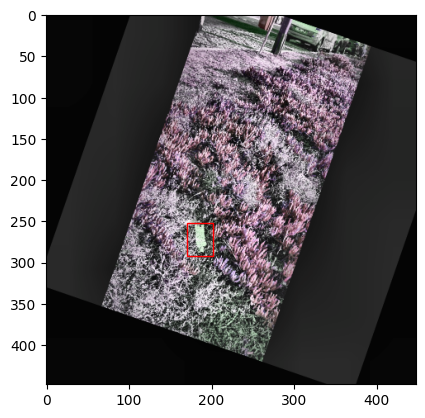

In [5]:
idx=120
sample = dataset[idx]

bboxes = cellboxes_to_boxes(torch.tensor([sample[1].tolist()]), S=7, B=2, C=1)
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(sample[0]), bboxes)